In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.impute import KNNImputer
import seaborn as sns
%matplotlib inline

#Bring in dataset of USA COVID-19 data by County and Date
cv19_cnty_dt =  pd.read_csv(r'./data/us-counties.csv')

#Bring in dataset of USA County Demographics
county = pd.read_csv('./data/counties.csv')

#Bring in dataset of USA County COVID-19 interventions
intrvnt = pd.read_csv('./data/interventions.csv')

#Bring in dataset of 2018 CDC social vulnerability index per county
svi = pd.read_csv(r'./data/2018_CDC_SVI.csv')

In [2]:
#Get the row from COVID-19 data with the most recent date by State and County
cv19_cnty = cv19_cnty_dt.groupby(['state','county','fips'], as_index=False)[['date','cases','deaths']].max()

# convert fips in the COVID-19 data to int64
cv19_cnty.fips = cv19_cnty.fips.astype('int')

#rename fips to FIPS to merge with other datasets
cv19_cnty = cv19_cnty.rename(columns={'fips':'FIPS'})

cv19_cnty.head()

,state,county,FIPS,date,cases,deaths
0,Alabama,Autauga,1001,2020-04-30,43,4
1,Alabama,Baldwin,1003,2020-04-30,174,3
2,Alabama,Barbour,1005,2020-04-30,39,1
3,Alabama,Bibb,1007,2020-04-30,42,0
4,Alabama,Blount,1009,2020-04-30,37,0


In [3]:
#How many counties have COVID-19 data?
cv19_cnty.shape[0]

2845

In [4]:
# PART 1: IDENTIFY BLACK AND HISPANIC COUNTIES

# Create general demographic variables from the County Demographic data
county['white']=county['NHWA_MALE'] + county['NHWA_FEMALE']

county['black']=county['NHBA_MALE'] + county['NHBA_FEMALE']

county['other_race']=county['NHIA_MALE'] + county['NHIA_FEMALE'] + county['NHAA_MALE'] + county['NHAA_FEMALE'] 
+ county['NHNA_MALE'] + county['NHNA_FEMALE'] + county['NHTOM_MALE'] + county['NHTOM_FEMALE']

county['hispanic'] = county['H_MALE'] + county['H_FEMALE']

county['percwhite'] = county['white']/county['POP_ESTIMATE_2018']*100
county['percblack'] = county['black']/county['POP_ESTIMATE_2018']*100
county['percother'] = county['other_race']/county['POP_ESTIMATE_2018']*100
county['perchisp'] = county['hispanic']/county['POP_ESTIMATE_2018']*100

county.loc[county['percblack'] > 50, 'blackCnty'] = 1
county.loc[county['percblack'] <= 50, 'blackCnty'] = 0

county.loc[county['perchisp'] > 50, 'HispCnty'] = 1
county.loc[county['perchisp'] <= 50, 'HispCnty'] = 0

county.columns

Index(['FIPS', 'State', 'Area_Name', 'Rural-urban_Continuum Code_2013',
       'Urban_Influence_Code_2013', 'Economic_typology_2015',
       'POP_ESTIMATE_2018', 'N_POP_CHG_2018', 'Births_2018', 'Deaths_2018',
       ...
       'white', 'black', 'other_race', 'hispanic', 'percwhite', 'percblack',
       'percother', 'perchisp', 'blackCnty', 'HispCnty'],
      dtype='object', length=357)

In [5]:
# Select Demographic variables of interest from County Demographic data
county = county.iloc[:,[0,1,2,6,55,111,112,113,116,119,122,248,312,329,347,348,349,350,351,352,353,354,355,356]]
county.head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,Total_Male,Total_Female,Total_age0to17,Total_age18to64,Total_age65plus,...,white,black,other_race,hispanic,percwhite,percblack,percother,perchisp,blackCnty,HispCnty
0,0,US,United States,327167434,61937.0,161128679.0,166038755.0,73399342.0,201336899.0,52431193.0,...,197487825.0,40898721.0,21142015.0,59722584.0,60.362923,12.500853,6.462139,18.254440,0.0,0.0
1,1000,AL,Alabama,4887871,49881.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,AL,Autauga County,55601,59338.0,26995.0,28606.0,13163.0,33785.0,8653.0,...,41316.0,10755.0,913.0,1649.0,74.308016,19.343177,1.642057,2.965774,0.0,0.0
3,1003,AL,Baldwin County,218022,57588.0,105657.0,112365.0,47110.0,126341.0,44571.0,...,181201.0,19151.0,3934.0,10131.0,83.111337,8.783976,1.804405,4.646779,0.0,0.0
4,1005,AL,Barbour County,24881,34382.0,13133.0,11748.0,5192.0,14857.0,4832.0,...,11356.0,11951.0,198.0,1064.0,45.641252,48.032635,0.795788,4.276355,0.0,0.0


In [6]:
# Drop the rows from County Demographic data with Country or State level aggregate data
county = county[~county['FIPS'].isin([0,1000,2000,4000,5000,6000,8000,9000,10000,11000,12000,13000,15000,16000,17000,
                                       18000,19000,20000,21000,22000,23000,24000,25000,26000,27000,28000,29000,30000,31000,
                                       32000,33000,34000,35000,36000,37000,38000,39000,40000,41000,42000,44000,45000,46000,
                                       47000,48000,49000,50000,51000,53000,54000,55000,56000,72000,
])]
county.shape

(3220, 24)

In [7]:
# What are the counties in the USA with more than 50% African-American Population?
blackCnty = county[county['blackCnty'] == 1]

# How many counties in the USA have more than 50% African-American Population?
blackCnty.shape[0]

97

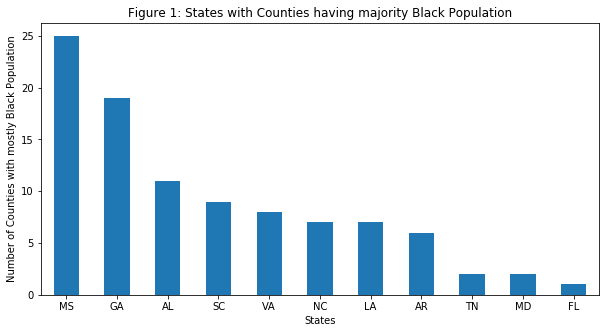

In [8]:
# Which states have the most counties with more than 50% African-American Population?
blackstate = pd.value_counts(blackCnty['State'].values, sort=True)
blackstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 1: States with Counties having majority Black Population')
plt.xlabel('States')
plt.ylabel('Number of Counties with mostly Black Population')
plt.savefig('images/figure01');

In [9]:
# What is the average population for counties in the USA with more than 50% African-American Population?
blackCnty['POP_ESTIMATE_2018'].mean()

68526.63917525773

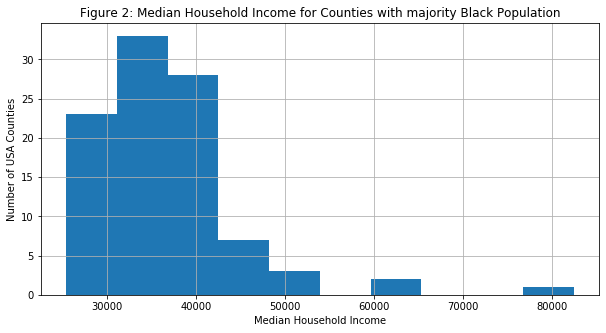

In [10]:
# What is the range of Median Household Income for counties in the USA with more than 50% African-American Population?
blackCnty['Median_Household_Income_2018'].hist(bins=10, figsize=(10,5))
plt.title('Figure 2: Median Household Income for Counties with majority Black Population')
plt.xlabel('Median Household Income')
plt.ylabel('Number of USA Counties')
plt.savefig('images/figure02');

In [11]:
# What is the average Median Household Income for the counties in the USA with more than 50% African-American Population?
blackCnty['Median_Household_Income_2018'].mean()

36302.113402061856

In [12]:
# What are the counties in the USA with more than 50% Hispanic Population?
hispCnty = county[county['HispCnty'] == 1]

# How many counties in the USA have more than 50% Hispanic Population?
hispCnty.shape[0]

101

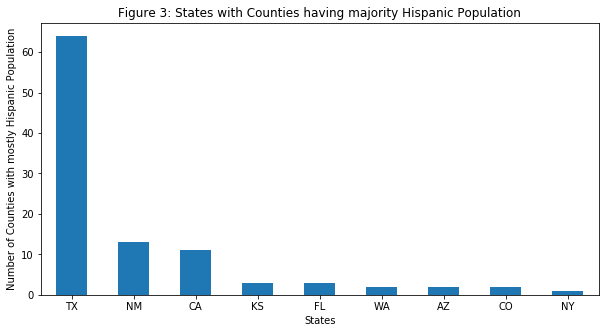

In [13]:
# Which states have the most counties with more than 50% Hispanic Population?
hispstate = pd.value_counts(hispCnty['State'].values, sort=True)
hispstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 3: States with Counties having majority Hispanic Population')
plt.xlabel('States')
plt.ylabel('Number of Counties with mostly Hispanic Population')
plt.savefig('images/figure03');

In [14]:
# What is the average population for counties in the USA with more than 50% Hispanic Population?
hispCnty['POP_ESTIMATE_2018'].mean()

177958.0099009901

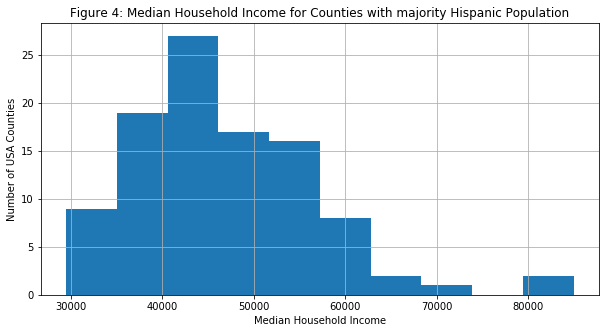

In [15]:
# What is the range of Median Household Income for counties in the USA with more than 50% Hispanic Population?
hispCnty['Median_Household_Income_2018'].hist(bins=10, figsize=(10,5))
plt.title('Figure 4: Median Household Income for Counties with majority Hispanic Population')
plt.xlabel('Median Household Income')
plt.ylabel('Number of USA Counties');
plt.savefig('images/figure04');

In [16]:
# What is the average Median Household Income for the counties in the USA with more than 50% Hispanic Population?
hispCnty['Median_Household_Income_2018'].mean()

46698.80198019802

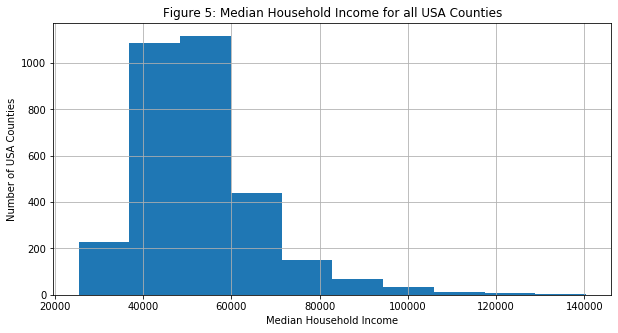

In [17]:
# What is the range of Median Household Income for the USA Counties?
county['Median_Household_Income_2018'].hist(bins=10, figsize=(10,5))
plt.title('Figure 5: Median Household Income for all USA Counties')
plt.xlabel('Median Household Income')
plt.ylabel('Number of USA Counties');
plt.savefig('images/figure05');

In [18]:
# What is the average Median Household Income for the USA Counties?
county['Median_Household_Income_2018'].mean()

52794.413244189745

In [19]:
# What is the average population per USA county?
county['POP_ESTIMATE_2018'].mean()

102597.07670807453

In [20]:
# PART 2: COVID-19 IN BLACK AND HISPANIC COUNTIES

# View the columns of the svi (social vulnerability index) data
svi.columns

Index(['FIPS', 'ST', 'STATE', 'ST_ABBR', 'COUNTY', 'FIPS.1', 'LOCATION',
       'AREA_SQMI', 'E_TOTPOP', 'M_TOTPOP',
       ...
       'F_CROWD', 'F_NOVEH', 'F_GROUPQ', 'F_THEME4', 'F_TOTAL', 'E_UNINSUR',
       'M_UNINSUR', 'EP_UNINSUR', 'MP_UNINSUR', 'E_DAYPOP'],
      dtype='object', length=124)

In [21]:
# The svi data has a column named FIPS and FIPS.1, we need FIPS.1 to merge with other data so drop FIPS column and rename FIPS.1 to FIPS
svi = svi.drop('FIPS', axis=1)
svi = svi.rename(columns={'FIPS.1':'FIPS'})

# Keep the needed variables from the svi data and rename columns to something intuitive based on documentation: 
# https://svi.cdc.gov/Documents/Data/2018_SVI_Data/SVI2018Documentation.pdf
svi = svi[['FIPS','AREA_SQMI','E_TOTPOP','E_HU','E_HH','EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT',
           'EP_MINRTY','EP_LIMENG','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_UNINSUR']].rename(columns={
    'AREA_SQMI':'area in square miles','E_TOTPOP':'Population','E_HU':'Housing units','E_HH':'Households','EP_POV':'below poverty %',
    'EP_UNEMP':'Unemployment Rate','EP_PCI':'Per capita income','EP_NOHSDP':'no high school diploma %','EP_AGE65':'Age 65 and older %',
    'EP_AGE17':'Age 17 and younger %','EP_DISABL':'Disabled %','EP_SNGPNT':'single parent households %','EP_MINRTY':'minority %', 
    'EP_MUNIT':'housing in structures with 10 or more units %','EP_UNINSUR':'Uninsured %','EP_LIMENG':'Limited English Speakers %',
    'EP_MOBILE':'Mobile Homes %','EP_NOVEH':'Households with no vehicle %','EP_GROUPQ':'Persons in Group Quarters %','EP_CROWD':'Crowded Houses %'
})

pd.set_option('display.max_columns', None)
svi.head()

,FIPS,area in square miles,Population,Housing units,Households,below poverty %,Unemployment Rate,Per capita income,no high school diploma %,Age 65 and older %,Age 17 and younger %,Disabled %,single parent households %,minority %,Limited English Speakers %,housing in structures with 10 or more units %,Mobile Homes %,Crowded Houses %,Households with no vehicle %,Persons in Group Quarters %,Uninsured %
0,1117,785.375019,211261,86077,78328,8.4,4.0,36576.0,7.8,14.3,24.0,11.2,6.0,21.9,1.6,7.6,8.0,1.1,2.9,1.4,6.8
1,1003,1589.793007,208107,111945,78622,10.6,4.4,31203.0,9.7,19.5,21.9,14.0,5.7,17.0,0.5,18.3,11.7,1.3,3.4,1.4,10.2
2,1115,631.603005,87306,36628,32172,13.2,5.3,24861.0,15.2,15.9,22.9,16.5,7.2,14.0,0.5,1.7,23.9,0.9,3.0,2.5,8.8
3,1033,592.744687,54495,26466,21799,16.3,5.9,24918.0,15.6,19.3,21.3,18.7,8.2,21.3,0.3,2.2,9.3,0.4,6.1,0.8,8.1
4,1089,801.582971,357560,159299,145256,13.2,5.8,35526.0,8.9,14.3,22.1,13.1,8.1,35.1,1.1,10.2,4.4,1.3,4.9,2.5,8.9


In [22]:
# The svi data uses -999 to represent null or no data
# replace -999 in svi data with null value
svi = svi.replace(-999, np.nan)

In [23]:
# View the data types of the intervention data
intrvnt.dtypes

FIPS                    int64
STATE                  object
AREA_NAME              object
stay at home          float64
>50 gatherings        float64
>500 gatherings       float64
public schools        float64
restaurant dine-in    float64
entertainment/gym     float64
federal guidelines    float64
foreign travel ban    float64
dtype: object

In [24]:
# The intervention data Contains the dates that counties (or states governing them) took various measures to mitigate 
# the spread of COVID-19. I want to use these as categorical variables for the presence or absence of each measure
# so dates will be replaced with 1 and NaN will be replaced with 0

# Fill columns containing dates with 1
date_vars = intrvnt.select_dtypes(include=['float']).columns
for col in date_vars:
    intrvnt[col].mask(intrvnt[col] > 0, 1, inplace=True)
    
# Fill columns containing NaN with 0
intrvnt = intrvnt.fillna(0)

#change the data type from float to integer
for col in date_vars:
    intrvnt[col] = intrvnt[col].astype('int') 

intrvnt.head()

,FIPS,STATE,AREA_NAME,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban
0,0,US,united states,0,0,0,0,0,0,0,0
1,1000,AL,alabama,0,1,1,1,1,0,1,1
2,1001,AL,autauga county,0,1,1,1,1,0,1,1
3,1003,AL,baldwin county,0,1,1,1,1,0,1,1
4,1005,AL,barbour county,0,1,1,1,1,0,1,1


In [25]:
# join the datasets cv19_cnty , intrvnt , county , and svi by FIPS
cvdf = county.merge(svi, on = 'FIPS', how = 'left').merge(intrvnt, on = 'FIPS', how = 'left').merge(cv19_cnty, on = 'FIPS', how = 'left')
cvdf.shape

(3220, 59)

In [26]:
# See which columns have missing data 
pd.set_option("max_rows", None)
missing_data = np.sum(cvdf.isnull())
missing_data

FIPS                                                     0
State                                                    0
Area_Name                                                0
POP_ESTIMATE_2018                                        0
Median_Household_Income_2018                            79
Total_Male                                              78
Total_Female                                            78
Total_age0to17                                          78
Total_age18to64                                         78
Total_age65plus                                         78
Total_age85plusr                                        78
Active Physicians per 100000 Population 2018 (AAMC)     78
Total Hospitals (2019)                                  78
ICU Beds                                                78
white                                                   79
black                                                   79
other_race                                              

In [27]:
# Handle missing COVID-19 values:
# Drop the repititive columns
cvdf = cvdf.drop({'state','county','STATE','AREA_NAME'}, axis = 1)

# fill missing dates with most recent date from COVID-19 data
cvdf['date'].fillna(method='ffill', inplace = True)

# fill number of cases and number of deaths with 0 for the counties with no COVID-19 data
cvdf.fillna(value = {'cases' : 0, 'deaths' : 0}, inplace = True)

# Answer Questions:
# What is the average number of COVID-19 cases and Deaths in counties with more than 50% African American population?
print ('average number of COVID-19 cases and Deaths in counties with more than 50% African American population')
print(cvdf.groupby(['blackCnty']).mean()[{'cases','deaths'}])
print(' ')

# What is the average number of COVID-19 cases and Deaths in counties with more than 50% Hispanic population?
print ('average number of COVID-19 cases and Deaths in counties with more than 50% Hispanic population')
print(cvdf.groupby(['HispCnty']).mean()[{'cases','deaths'}])
print(' ')

# What is the average number of COVID-19 cases and Deaths across all USA counties?
print('average number of COVID-19 cases and Deaths across all USA counties')
print(cvdf[{'cases','deaths'}].mean())

average number of COVID-19 cases and Deaths in counties with more than 50% African American population
              deaths       cases
blackCnty                       
0.0        14.260184  284.218791
1.0        14.360825  297.298969
 
average number of COVID-19 cases and Deaths in counties with more than 50% Hispanic population
             deaths       cases
HispCnty                       
0.0       14.503289  285.879934
1.0        7.039604  246.782178
 
average number of COVID-19 cases and Deaths across all USA counties
deaths     13.913665
cases     277.684472
dtype: float64


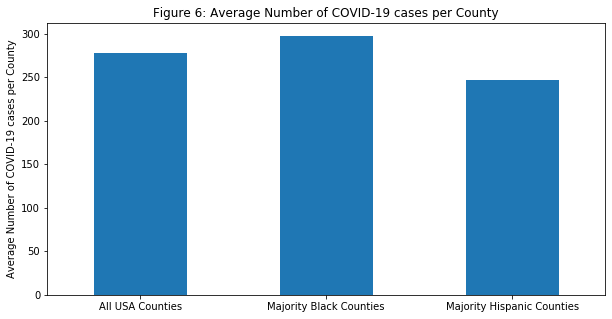

In [28]:
# Visualize average number of COVID-19 cases by Black Counties, Hispanic Counties, and all Counties
AvgCOVID = pd.DataFrame([cvdf['cases'].mean(),cvdf.loc[cvdf['blackCnty']==1, 'cases'].mean(),
                         cvdf.loc[cvdf['HispCnty']==1, 'cases'].mean(),],
                              index = ['All USA Counties','Majority Black Counties','Majority Hispanic Counties'])

AvgCOVID.plot.bar(figsize=(10,5), legend=False, rot=0)
plt.title('Figure 6: Average Number of COVID-19 cases per County')
plt.ylabel('Average Number of COVID-19 cases per County');
plt.savefig('images/figure06');

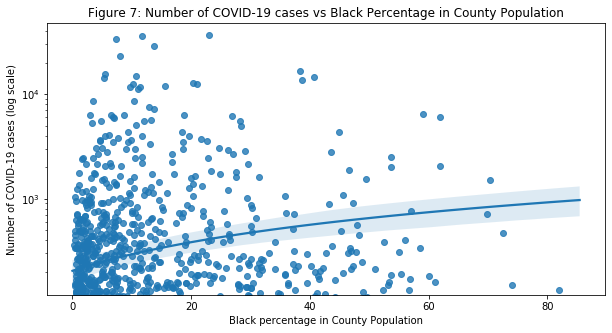

In [29]:
# Number of COVID-19 cases vs percentage of Blacks in the County Population
plt.figure(figsize=(10,5))
ax1 = sns.regplot(x='percblack',y='cases', data=cvdf)
plt.title('Figure 7: Number of COVID-19 cases vs Black Percentage in County Population')
plt.xlabel('Black percentage in County Population')
plt.ylabel('Number of COVID-19 cases (log scale)')
ax1.set_yscale('log')
plt.savefig('images/figure07');

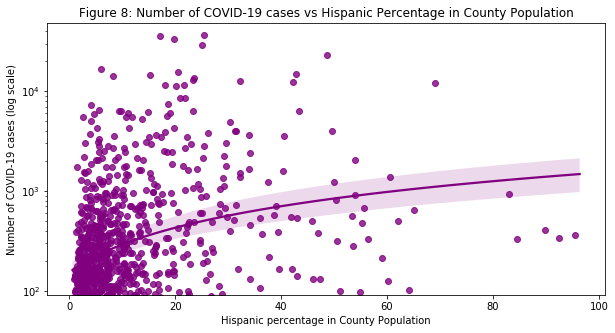

In [30]:
# Number of COVID-19 cases vs percentage of Hispanics in the County Population
plt.figure(figsize=(10,5))
ax2 = sns.regplot(x='perchisp',y='cases', data=cvdf, color='purple')
plt.title('Figure 8: Number of COVID-19 cases vs Hispanic Percentage in County Population')
plt.xlabel('Hispanic percentage in County Population')
plt.ylabel('Number of COVID-19 cases (log scale)')
ax2.set_yscale('log')
plt.savefig('images/figure08');

In [31]:
# PART 3: COVID-19 AND INCOME

# What is the average number of cases among the counties with the top 1% highest median household income
cvdf['Med_HHInc_Percentile_rank']=cvdf.Median_Household_Income_2018.rank(pct=True)

cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.99) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.90), 'Med_HHInc_Percentile'] = '90% - 99%'
cvdf.loc[cvdf['Med_HHInc_Percentile_rank'] >= 0.99, 'Med_HHInc_Percentile'] = '>=99%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.90) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.75), 'Med_HHInc_Percentile'] = '75% - 90%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.75) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.50), 'Med_HHInc_Percentile'] = '50% - 75%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.50) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0.25), 'Med_HHInc_Percentile'] = '25% - 50%'
cvdf.loc[(cvdf['Med_HHInc_Percentile_rank'] < 0.25) & 
         (cvdf['Med_HHInc_Percentile_rank'] >= 0), 'Med_HHInc_Percentile'] = '0% - 25%'

print ('average number of COVID-19 cases and Deaths by county median household income')
print(cvdf.groupby(['Med_HHInc_Percentile']).mean()[{'cases','deaths'}])

average number of COVID-19 cases and Deaths by county median household income
                          deaths        cases
Med_HHInc_Percentile                         
0% - 25%                2.583439    51.107006
25% - 50%               6.645860   114.929936
50% - 75%               6.383439   148.968153
75% - 90%              22.664544   473.929936
90% - 99%              64.063604  1253.166078
>=99%                 116.906250  2156.187500


In [32]:
# What is the average number of cases among the counties with the top 1% highest PER CAPITA INCOME
cvdf['PCI_Percentile_rank']=cvdf['Per capita income'].rank(pct=True)

cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.99) & 
         (cvdf['PCI_Percentile_rank'] >= 0.90), 'PCI_Percentile'] = '90% - 99%'
cvdf.loc[cvdf['PCI_Percentile_rank'] >= 0.99, 'PCI_Percentile'] = '>=99%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.90) & 
         (cvdf['PCI_Percentile_rank'] >= 0.75), 'PCI_Percentile'] = '75% - 90%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.75) & 
         (cvdf['PCI_Percentile_rank'] >= 0.50), 'PCI_Percentile'] = '50% - 75%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.50) & 
         (cvdf['PCI_Percentile_rank'] >= 0.25), 'PCI_Percentile'] = '25% - 50%'
cvdf.loc[(cvdf['PCI_Percentile_rank'] < 0.25) & 
         (cvdf['PCI_Percentile_rank'] >= 0), 'PCI_Percentile'] = '0% - 25%'

print ('average number of COVID-19 cases and Deaths by county Per capita income')
print(cvdf.groupby(['PCI_Percentile']).mean()[{'cases','deaths'}])

average number of COVID-19 cases and Deaths by county Per capita income
                    deaths        cases
PCI_Percentile                         
0% - 25%          1.804726    43.456468
25% - 50%         4.734161    84.778882
50% - 75%         7.434783   161.920497
75% - 90%        16.447205   378.080745
90% - 99%        57.598616  1115.494810
>=99%           271.666667  4715.363636


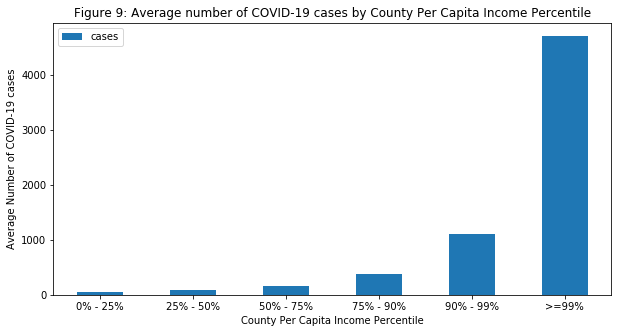

In [33]:
AvgCasesbyPCI = pd.DataFrame(cvdf.groupby(['PCI_Percentile']).mean()['cases']).reset_index()
AvgCasesbyPCI.plot.bar(x='PCI_Percentile',y='cases', figsize=(10,5), rot=0)
plt.title('Figure 9: Average number of COVID-19 cases by County Per Capita Income Percentile')
plt.xlabel('County Per Capita Income Percentile')
plt.ylabel('Average Number of COVID-19 cases')
plt.savefig('images/figure09');

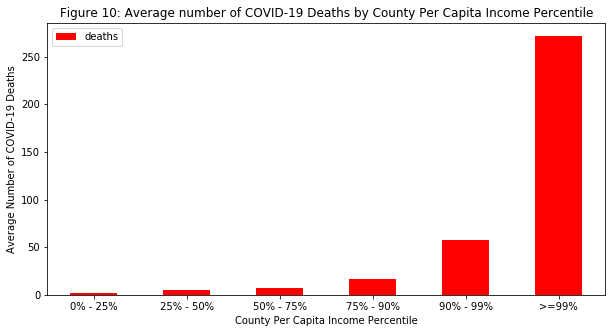

In [34]:
AvgDeathsbyPCI = pd.DataFrame(cvdf.groupby(['PCI_Percentile']).mean()['deaths']).reset_index()
AvgDeathsbyPCI.plot.bar(x='PCI_Percentile',y='deaths', color='r', figsize=(10,5), rot=0)
plt.title('Figure 10: Average number of COVID-19 Deaths by County Per Capita Income Percentile')
plt.xlabel('County Per Capita Income Percentile')
plt.ylabel('Average Number of COVID-19 Deaths')
plt.savefig('images/figure10');

In [35]:
# Which counties have the highest median household income?
HghMedHHI = cvdf[cvdf['Med_HHInc_Percentile_rank'] >= 0.99]
HghMedHHI = HghMedHHI.sort_values(by='Med_HHInc_Percentile_rank',ascending=False)
HghMedHHI.iloc[:,[0,1,2,3,4,30,53,54,55]].head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,Per capita income,cases,deaths,Med_HHInc_Percentile_rank
2872,51107,VA,Loudoun County,406850,140382.0,53408.0,746.0,15.0,1.000000
2925,51610,VA,Falls Church city,14772,137551.0,69775.0,26.0,2.0,0.999682
228,6085,CA,Santa Clara County,1937570,125933.0,52451.0,2163.0,112.0,0.999363
1810,35028,NM,Los Alamos County,19101,124947.0,56410.0,6.0,0.0,0.999045
206,6041,CA,Marin County,259666,122933.0,69275.0,237.0,13.0,0.998727


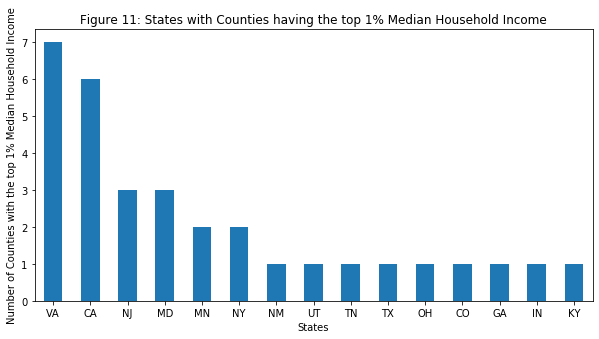

In [36]:
# Which states have the most counties with the top 1% Median Household Income?
HghMedHHIstate = pd.value_counts(HghMedHHI['State'].values, sort=True)
HghMedHHIstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 11: States with Counties having the top 1% Median Household Income')
plt.xlabel('States')
plt.ylabel('Number of Counties with the top 1% Median Household Income')
plt.savefig('images/figure11');

In [37]:
# Which counties have the highest per capita income?
HghPCI = cvdf[cvdf['PCI_Percentile_rank'] >= 0.99]
HghPCI = HghPCI.sort_values(by='PCI_Percentile_rank',ascending=False)
HghPCI.iloc[:,[0,1,2,3,4,30,53,54,57]].head()

,FIPS,State,Area_Name,POP_ESTIMATE_2018,Median_Household_Income_2018,Per capita income,cases,deaths,PCI_Percentile_rank
1858,36061,NY,New York County,1628701,84610.0,72832.0,0.0,0.0,1.000000
2925,51610,VA,Falls Church city,14772,137551.0,69775.0,26.0,2.0,0.999689
206,6041,CA,Marin County,259666,122933.0,69275.0,237.0,13.0,0.999379
2826,51013,VA,Arlington County,237521,120950.0,69051.0,967.0,41.0,0.999068
223,6075,CA,San Francisco County,883305,110601.0,64157.0,1502.0,25.0,0.998757


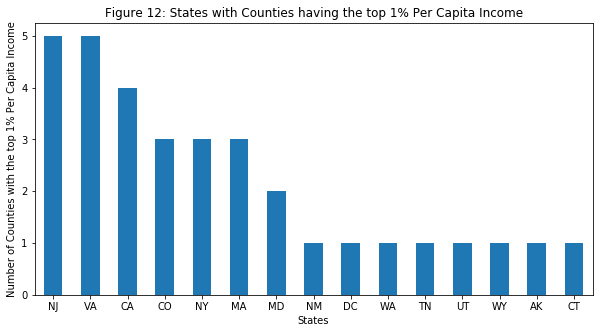

In [38]:
# Which states have the most counties with the top 1% Per Capita Income?
HghPCIstate = pd.value_counts(HghPCI['State'].values, sort=True)
HghPCIstate.plot.bar(figsize=(10,5), rot=0)
plt.title('Figure 12: States with Counties having the top 1% Per Capita Income')
plt.xlabel('States')
plt.ylabel('Number of Counties with the top 1% Per Capita Income')
plt.savefig('images/figure12');

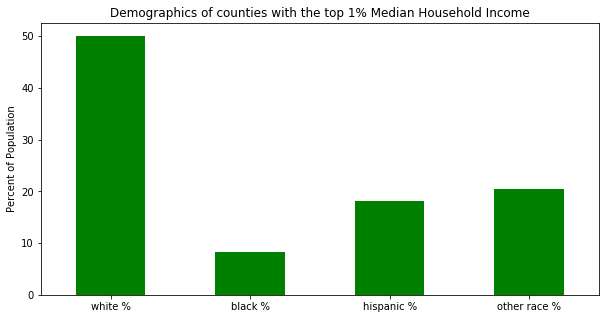

In [39]:
# What are the demographics of counties with the highest median household income?
HghMedHHIdemo = pd.DataFrame([np.sum(HghMedHHI['white'])/np.sum(HghMedHHI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghMedHHI['black'])/np.sum(HghMedHHI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghMedHHI['hispanic'])/np.sum(HghMedHHI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghMedHHI['other_race'])/np.sum(HghMedHHI['POP_ESTIMATE_2018'])*100],
                              index = ['white %','black %','hispanic %','other race %'])

HghMedHHIdemo.plot.bar(color='g', figsize=(10,5), legend=False, rot=0)
plt.title('Demographics of counties with the top 1% Median Household Income')
plt.ylabel('Percent of Population');

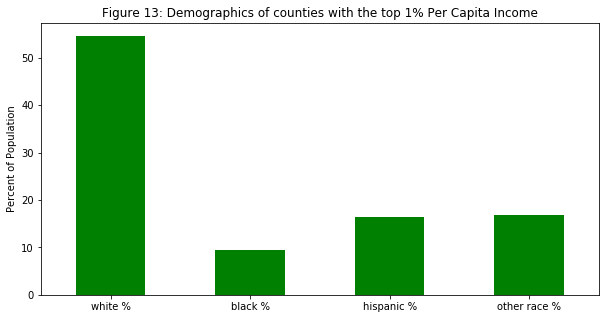

In [40]:
# What are the demographics of counties with the highest per capita income?
HghPCIdemo = pd.DataFrame([np.sum(HghPCI['white'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['black'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['hispanic'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100,
                              np.sum(HghPCI['other_race'])/np.sum(HghPCI['POP_ESTIMATE_2018'])*100],
                              index = ['white %','black %','hispanic %','other race %'])

HghPCIdemo.plot.bar(color='g', figsize=(10,5), legend=False, rot=0)
plt.title('Figure 13: Demographics of counties with the top 1% Per Capita Income')
plt.ylabel('Percent of Population');
plt.savefig('images/figure13');

In [41]:
# What is the average population of the counties that have the highest median household income?
HghMedHHI['POP_ESTIMATE_2018'].mean()

463117.6875

In [42]:
# What is the average population of the counties that have the highest per capita income?
HghPCI['POP_ESTIMATE_2018'].mean()

623107.8181818182

In [49]:
# What is the average median household income of the counties that have the highest median household income?
HghMedHHI['Median_Household_Income_2018'].mean()

112714.34375

In [50]:
# What is the average per capita income of the counties that have the highest per capita?
HghMedHHI['Per capita income'].mean()

50929.875

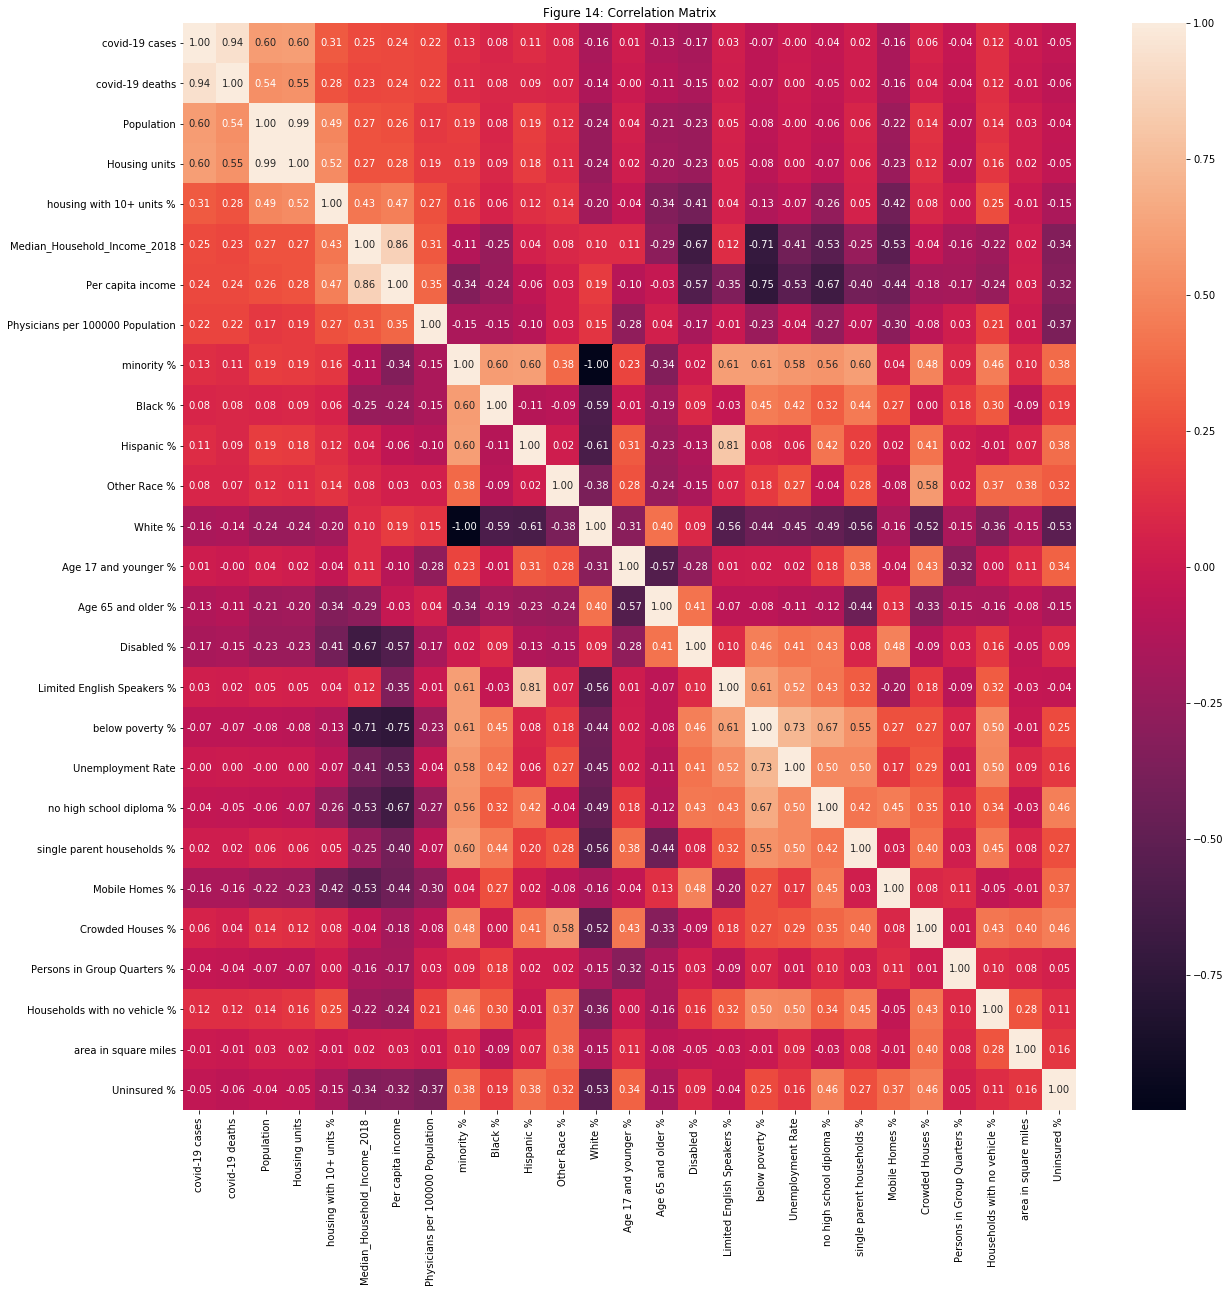

In [43]:
# PART 4: FACTORS RELATING TO COVID-19

# Create dataframe for correlation matrix
corrvars = cvdf[['cases','deaths','Population','Housing units',
                 'housing in structures with 10 or more units %',
                 'Median_Household_Income_2018','Per capita income',
                 'Active Physicians per 100000 Population 2018 (AAMC)',
                 'minority %','percblack','perchisp',
                 'percother','percwhite','Age 17 and younger %','Age 65 and older %',
                 'Disabled %','Limited English Speakers %','below poverty %',
                 'Unemployment Rate','no high school diploma %',
                 'single parent households %','Mobile Homes %','Crowded Houses %',
                 'Persons in Group Quarters %','Households with no vehicle %',
                 'area in square miles','Uninsured %']].rename(columns={
    'cases':'covid-19 cases','deaths':'covid-19 deaths','percwhite':'White %',
    'percblack':'Black %','perchisp':'Hispanic %','percother':'Other Race %',
    'Active Physicians per 100000 Population 2018 (AAMC)':'Physicians per 100000 Population',
    'housing in structures with 10 or more units %':'housing with 10+ units %'
})

# Correlation Matrix 
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corrvars.corr(), annot=True, fmt='.2f', ax = ax)
ax.set_title('Figure 14: Correlation Matrix')
plt.savefig('images/figure14');

In [44]:
#descriptive stats
corrvars.describe()

,covid-19 cases,covid-19 deaths,Population,Housing units,housing with 10+ units %,Median_Household_Income_2018,Per capita income,Physicians per 100000 Population,minority %,Black %,Hispanic %,Other Race %,White %,Age 17 and younger %,Age 65 and older %,Disabled %,Limited English Speakers %,below poverty %,Unemployment Rate,no high school diploma %,single parent households %,Mobile Homes %,Crowded Houses %,Persons in Group Quarters %,Households with no vehicle %,area in square miles,Uninsured %
count,3220.000000,3220.000000,3.220000e+03,3.220000e+03,3220.000000,3141.000000,3219.000000,3142.000000,3220.000000,3141.000000,3141.000000,3141.000000,3141.000000,3220.000000,3220.000000,3220.000000,3220.000000,3219.000000,3219.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,277.684472,13.913665,1.013323e+05,4.284082e+04,4.662795,52794.413244,26639.001553,254.937556,25.335590,8.995580,9.634191,3.439415,76.008147,22.323851,18.370217,16.042422,3.288789,16.390276,6.071295,13.743913,8.447174,12.629193,2.447702,3.459068,6.581739,1098.148121,9.972516
std,1643.492339,89.159299,3.260964e+05,1.255043e+05,5.697776,13880.120635,6923.981359,42.281927,23.076184,14.300597,13.798991,7.902371,20.178068,3.465786,4.546162,4.532972,10.527852,8.226827,3.588123,6.678021,2.871275,9.693831,2.423913,4.542728,4.690854,3574.154618,5.093093
min,0.000000,0.000000,7.500000e+01,7.000000e+01,0.000000,25385.000000,5974.000000,191.300000,0.000000,0.000000,0.610451,0.000000,2.691288,5.300000,3.800000,3.800000,0.000000,2.300000,0.000000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,2.046443,1.700000
25%,3.000000,0.000000,1.121425e+04,5.594250e+03,1.300000,43681.000000,22495.500000,227.600000,7.400000,0.708630,2.400223,0.855467,64.329889,20.200000,15.500000,12.900000,0.300000,11.100000,4.000000,8.800000,6.700000,5.000000,1.200000,1.200000,4.275000,419.024185,6.100000
50%,16.000000,0.000000,2.595050e+04,1.251950e+04,2.900000,50568.000000,26093.000000,247.100000,16.750000,2.228226,4.399721,1.344785,83.384218,22.300000,18.000000,15.500000,0.800000,14.900000,5.500000,12.300000,8.200000,10.600000,1.900000,1.900000,5.700000,604.515692,9.000000
75%,77.000000,3.000000,6.655225e+04,3.100650e+04,5.800000,58848.000000,29972.000000,278.800000,36.700000,10.222689,9.996491,2.766948,92.297008,24.100000,20.800000,18.700000,2.000000,19.500000,7.200000,17.700000,9.900000,18.425000,2.900000,3.800000,7.800000,914.630785,12.500000
max,36513.000000,2111.000000,1.009805e+07,3.524321e+06,89.400000,140382.000000,72832.000000,847.000000,100.000000,85.414352,96.359551,90.991208,97.887219,40.500000,55.600000,34.200000,85.600000,64.200000,38.400000,66.300000,25.700000,59.300000,49.300000,55.700000,87.800000,145573.832761,45.600000


In [45]:
# see percent of missing data per column
missing_data = np.sum(cvdf.isnull())/cvdf.shape[0]*100
missing_data

FIPS                                                   0.000000
State                                                  0.000000
Area_Name                                              0.000000
POP_ESTIMATE_2018                                      0.000000
Median_Household_Income_2018                           2.453416
Total_Male                                             2.422360
Total_Female                                           2.422360
Total_age0to17                                         2.422360
Total_age18to64                                        2.422360
Total_age65plus                                        2.422360
Total_age85plusr                                       2.422360
Active Physicians per 100000 Population 2018 (AAMC)    2.422360
Total Hospitals (2019)                                 2.422360
ICU Beds                                               2.422360
white                                                  2.453416
black                                   

In [46]:
# Handle remainng missing values prior to modeling
# Use K-Nearest Neighbors to fill missing values based on other similar Counties:
# seperate variables to be imputed
cvdf1=cvdf.drop(cvdf.columns[[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,25,26,27,28,29,
                              30,31,32,33,34,35,36,37,38,39,40,41,42,43,55,56,57,58]],axis=1)
cvdf2=cvdf.iloc[:,[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43]]

# impute values using KNN
imputer = KNNImputer(n_neighbors=2)
df_filled = pd.DataFrame(imputer.fit_transform(cvdf2), columns = cvdf2.columns)

# combine the imputed variables with the other variables
cv19 = cvdf1.join(df_filled)

# Find the Black and Hispanic Counties for the imputed values
cv19.loc[cv19['percblack'] > 50, 'blackCnty'] = 1
cv19.loc[cv19['percblack'] <= 50, 'blackCnty'] = 0

cv19.loc[cv19['perchisp'] > 50, 'HispCnty'] = 1
cv19.loc[cv19['perchisp'] <= 50, 'HispCnty'] = 0

cv19.head()

,FIPS,State,Area_Name,blackCnty,HispCnty,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,date,cases,deaths,POP_ESTIMATE_2018,Median_Household_Income_2018,Total_Male,Total_Female,Total_age0to17,Total_age18to64,Total_age65plus,Total_age85plusr,Active Physicians per 100000 Population 2018 (AAMC),Total Hospitals (2019),ICU Beds,white,black,other_race,hispanic,percwhite,percblack,percother,perchisp,area in square miles,Population,Housing units,Households,below poverty %,Unemployment Rate,Per capita income,no high school diploma %,Age 65 and older %,Age 17 and younger %,Disabled %,single parent households %,minority %,Limited English Speakers %,housing in structures with 10 or more units %,Mobile Homes %,Crowded Houses %,Households with no vehicle %,Persons in Group Quarters %,Uninsured %
0,1001,AL,Autauga County,0.0,0.0,0,1,1,1,1,0,1,1,2020-04-30,43.0,4.0,55601.0,59338.0,26995.0,28606.0,13163.0,33785.0,8653.0,871.0,217.1,1.148905,6.0,41316.0,10755.0,913.0,1649.0,74.308016,19.343177,1.642057,2.965774,594.443459,55200.0,23315.0,21115.0,15.4,4.2,29372.0,11.3,14.6,24.2,19.3,7.5,25.0,0.8,3.8,18.4,1.4,5.6,1.0,7.1
1,1003,AL,Baldwin County,0.0,0.0,0,1,1,1,1,0,1,1,2020-04-30,174.0,3.0,218022.0,57588.0,105657.0,112365.0,47110.0,126341.0,44571.0,4304.0,217.1,4.505074,51.0,181201.0,19151.0,3934.0,10131.0,83.111337,8.783976,1.804405,4.646779,1589.793007,208107.0,111945.0,78622.0,10.6,4.4,31203.0,9.7,19.5,21.9,14.0,5.7,17.0,0.5,18.3,11.7,1.3,3.4,1.4,10.2
2,1005,AL,Barbour County,0.0,0.0,0,1,1,1,1,0,1,1,2020-04-30,39.0,1.0,24881.0,34382.0,13133.0,11748.0,5192.0,14857.0,4832.0,472.0,217.1,0.514126,5.0,11356.0,11951.0,198.0,1064.0,45.641252,48.032635,0.795788,4.276355,885.001636,25782.0,11937.0,9186.0,28.9,9.5,18461.0,27.0,18.0,21.1,22.2,12.8,53.9,1.6,1.3,29.2,3.4,9.2,11.2,11.2
3,1007,AL,Bibb County,0.0,0.0,0,1,1,1,1,0,1,1,2020-04-30,42.0,0.0,22400.0,46064.0,11921.0,10479.0,4587.0,14123.0,3690.0,363.0,217.1,0.462860,0.0,16708.0,4731.0,138.0,588.0,74.589286,21.120536,0.616071,2.625000,622.461089,22527.0,9161.0,6840.0,14.0,7.5,20199.0,16.8,16.3,20.7,16.7,6.0,25.4,0.3,2.4,28.5,0.8,6.0,9.3,7.9
4,1009,AL,Blount County,0.0,0.0,0,1,1,1,1,0,1,1,2020-04-30,37.0,0.0,57840.0,50412.0,28500.0,29340.0,13392.0,33900.0,10548.0,1032.0,217.1,1.195171,6.0,50255.0,846.0,459.0,5536.0,86.886238,1.462656,0.793568,9.571231,644.830460,57645.0,24222.0,20600.0,14.4,4.1,22656.0,19.8,17.8,23.4,14.2,7.0,12.9,1.7,0.9,25.2,1.6,4.2,0.9,11.0


In [47]:
# What relates to covid-19 infection 
# modeling using county demographics, intervention, and social vulnerability index data

#Split into explanatory and response variables
y1 = cv19['cases']
X1 = cv19[['POP_ESTIMATE_2018','Median_Household_Income_2018','Total_Male','Total_Female',
           'Total_age0to17','Total_age18to64','Total_age65plus','Total_age85plusr',
           'Active Physicians per 100000 Population 2018 (AAMC)','Total Hospitals (2019)','ICU Beds',
           'white','black','other_race','hispanic',
           'area in square miles','Population','Housing units','Households',
           'below poverty %','Unemployment Rate','Per capita income','no high school diploma %',
           'Age 65 and older %','Age 17 and younger %','Disabled %','single parent households %',
           'minority %','Limited English Speakers %','housing in structures with 10 or more units %',
           'Mobile Homes %','Crowded Houses %','Households with no vehicle %',
           'Persons in Group Quarters %','Uninsured %','stay at home','>50 gatherings',
           '>500 gatherings','public schools','restaurant dine-in','entertainment/gym'           
]]

#Split into train and test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

# Instantiate the model
lm_model1 = LinearRegression(normalize=True) 

#Fit
lm_model1.fit(X1_train, y1_train) 

#Predict using your model
y1_test_preds = lm_model1.predict(X1_test)
y1_train_preds = lm_model1.predict(X1_train)

#Score using your model
test_score1 = r2_score(y1_test, y1_test_preds)
train_score1 = r2_score(y1_train, y1_train_preds)

print("The r-squared score for the model on the Test data was {} on {} values.".format(test_score1, len(y1_test)))
print("The r-squared score for the model on the Training data was {} on {} values.".format(train_score1, len(y1_train)))


The r-squared score for the model on the Test data was 0.5489851946176638 on 966 values.
The r-squared score for the model on the Training data was 0.5587876373165133 on 2254 values.


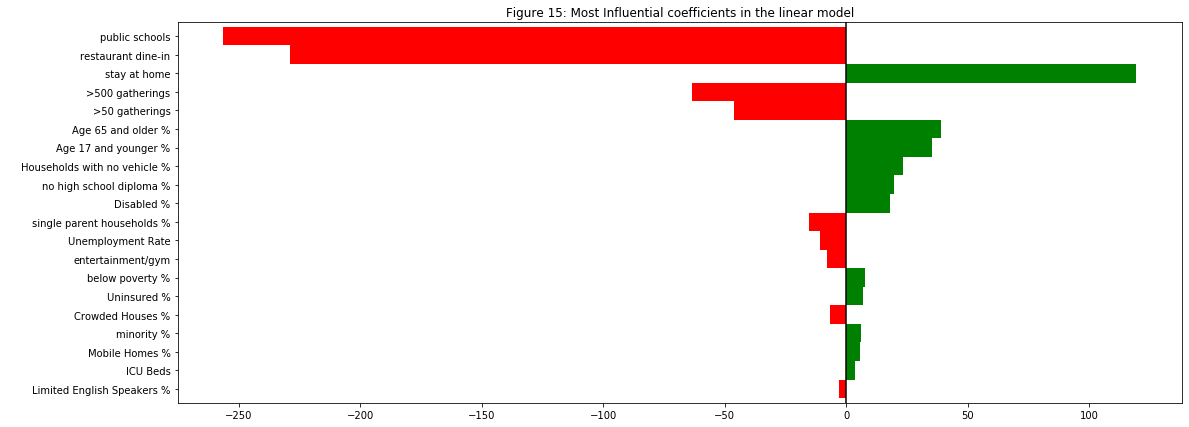

In [48]:
# View coefficients of the COVID-19 infection model 
def cases_coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model1.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model1.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=True)
    return coefs_df

#Use the function
coef_df1 = cases_coef_weights(lm_model1.coef_, X1_train)
coef_df1 = coef_df1.drop('abs_coefs', axis=1).set_index('est_int')

#View the top results
coef_df = coef_df1.iloc[21:,:]
coef_df.plot.barh(width=1, figsize=(18,7), legend=False, color=[np.where(coef_df['coefs']>0, 'g', 'r')], rot=0)
plt.title('Figure 15: Most Influential coefficients in the linear model')
plt.axvline(0, color='k')
plt.ylabel(' ');
plt.savefig('images/figure15');